# Actin Analysis

Filamentous actin (F-actin) is a protein that plays a role in many essential cellular processes. In neurons, it has been shown that neuronal activity regulates the F-actin cytoskeleton. We were interested in studying how neuronal activity regulates the F-actin-based lattice in dendrites and axons of cultured hippocampal neurons, using STimulated Emission Depletion (STED) nanoscopy.

[Paper](https://www.nature.com/articles/s41598-020-68180-2) : Lavoie-Cardinal, F. *et al*. (2020). Neuronal activity remodels the F-actin based submembrane lattice in dendrites but not axons of hippocampal neurons. Scientific reports.

We credit Anthony Bilodeau (Flavie Lavoie-Cardinal's lab) for this notebook.

# 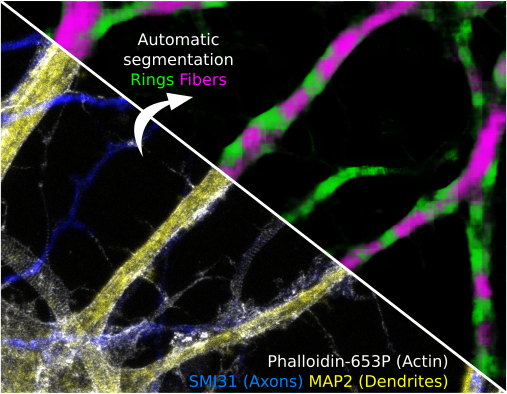

# Download data and set environment

Installing different librairies is often required when using Python. Librairies are a way of not having to implement everything from scratch. Python librairies are very similar to ImageJ/Fiji plugins.

With Colab most packages are already *pre-installed* which simplifies the installation process.


In [10]:
# @markdown Run cell. Installs required packages.

%load_ext autoreload
%autoreload 2

!pip install matplotlib_scalebar
!pip install imagecodecs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


In [6]:
# @markdown Run cell. Downloads required data and code

import os

# Changes directory to the main folder
home = os.path.expanduser("~")
os.chdir(home)

if not os.path.isdir(f"{home}/DL4HBM-2020"):
    !git clone https://github.com/FLClab/DL4HBM-2020.git
else:
    os.chdir(f"{home}/DL4HBM-2020")
    !git pull

os.chdir(f"{home}/DL4HBM-2020")

if not os.path.isfile(f"{home}/DL4HBM-2020/raw_data/archive.zip"):
    !wget -O /content/DL4HBM-2020/raw_data/archive.zip https://s3.valeria.science/flclab-public-data/data/QSW2023-example-images.zip
!unzip -oq /content/DL4HBM-2020/raw_data/archive.zip -d /content/DL4HBM-2020/raw_data

if not os.path.isdir(f"{home}/DL4HBM-2020/trained-networks/archive.zip"):
    !wget -O /content/DL4HBM-2020/trained-networks/archive.zip https://s3.valeria.science/flclab-public-data/data/QSW2023-actin-models.zip
!unzip -oq /content/DL4HBM-2020/trained-networks/archive.zip -d /content/DL4HBM-2020/trained-networks

Cloning into 'DL4HBM-2020'...
remote: Enumerating objects: 3234, done.
remote: Counting objects: 100% (332/332), done. Counting objects:  34% (113/332)
remote: Compressing objects: 100% (125/125), done.
Receiving objects:  92% (2976/3234), 740.64 MiB | 6.68 MiB/s3234)Receiving objects:   2% (65/3234)Receiving objects:   3% (98/3234)Receiving objects:   7% (227/3234)Receiving objects:   9% (292/3234)Receiving objects:  14% (453/3234), 5.36 MiB | 10.71 MiB/sReceiving objects:  18% (583/3234), 5.36 MiB | 10.71 MiB/sReceiving objects:  23% (744/3234), 5.36 MiB | 10.71 MiB/sReceiving objects:  25% (809/3234), 5.36 MiB | 10.71 MiB/sReceiving objects:  27% (874/3234), 5.36 MiB | 10.71 MiB/sReceiving objects:  33% (1068/3234), 5.36 MiB | 10.71 MiB/sReceiving objects:  36% (1165/3234), 5.36 MiB | 10.71 MiB/sReceiving objects:  39% (1268/3234), 13.61 MiB | 13.41 MiB/sReceiving objects:  43% (1391/3234), 13.61 MiB | 13.41 MiB/sReceiving objects:  45% (1456/3234), 13.61 MiB | 13.41 MiB/sReceiving 

# Supervised Learning

This notebook aims at introducing the concepts behind machine learning and deep learning (ML/DL). This is more or less a recipe that can be followed to segment biological structures in the images. It will also provide some guidance about the challenges that inevitably arise when using DL models.

This notebook presents challenges that can be faced when creating a ML/DL data analysis pipeline.
1. Look at the data
1. Define the task (classification, segmentation, etc.)
1. Look at the prediction
1. Quantitatively measure the performance of the model
1. Evaluate the generalization of the model

In [1]:
# @markdown Run cell. Loads necessary libraries.

import numpy
import glob, os
import torch
import warnings
import sys
import pickle
import skimage
import tifffile
import random
import matplotlib
import ipywidgets as widgets

from ipywidgets import interact, interact_manual, fixed
from matplotlib import pyplot, patches
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics import (confusion_matrix, f1_score, precision_score, recall_score,
                             precision_recall_curve)
from skimage import filters, io, draw, morphology
from scipy.spatial import distance
from collections import defaultdict

CUDA = torch.cuda.is_available()
if not CUDA:
  print("Cuda is not available in the current notebook.")
  print("You can change this setting in Edit/Notebook settings.")

CONTRAST_VALUE = 0.995

In [2]:
# @markdown Run cell. Loads necessary functions.

from tqdm.auto import tqdm

cmap_green = matplotlib.colors.LinearSegmentedColormap.from_list('black_green',["k", "g"], N=256)
cmap_magenta = matplotlib.colors.LinearSegmentedColormap.from_list('black_magenta',["k", "m"], N=256)
cmap_yellow = matplotlib.colors.LinearSegmentedColormap.from_list('black_yellow',["k", "y"], N=256)
cmap_blue = matplotlib.colors.LinearSegmentedColormap.from_list('black_blue',["k", "cyan"], N=256)

class MetricCalculator:
  """
  Implements a MetricCalculator class to facilite the calculation of metric
  between the targets and the predictions
  """
  def __init__(self, targets, predictions, foregrounds=None):
    """
    Instantiates the `MetricCalculator` class

    :param targets: A `numpy.ndarray` of the targets
    :param targets: A `numpy.ndarray` of the predictions
    :param targets: A `numpy.ndarray` of the foregrounds
    """
    # Assign member variables
    self.targets = targets
    self.predictions = predictions
    if isinstance(foregrounds, type(None)):
      self.foregrounds = [None] * len(self.targets)
    else:
      self.foregrounds = foregrounds

  def get(self, metric_names, **kwargs):
    """
    Implements a get method to get the metric score between the targets
    and the predictions

    :param metrics: A `list` of the metrics to compute

    :returns : A `list` of scores
    """
    try:
      scorers = [getattr(self, f"_{metric_name}") for metric_name in metric_names]
    except AttributeError:
      warnings.warn(f"The chosen method `{metric_name}` does not exist.\nExiting...", category=UserWarning)
      return
    all_scores = []
    for t, p, f in zip(tqdm(self.targets, leave=False), self.predictions, self.foregrounds):
      if p.ndim > 2:
        p = numpy.argmax(p, axis=0) if p.shape[0]>1 else p.squeeze()
      if not isinstance(f, type(None)):
        t = t[f.astype(bool)]
        p = p[f.astype(bool)]
      if (not numpy.any(t)) and ((not numpy.any(p)) or ("precision_recall_curve" in metric_names)):
        continue
      scores = [scorer(t, p, **kwargs) for scorer in scorers]
      all_scores.append(scores)
    if "precision_recall_curve" in metric_names:
      return all_scores
    return numpy.array(all_scores).T

  def _confusion_matrix(self, target, prediction, normalized=False):
    """
    Computes the confusion matrix between the target and the prediction

    :param target: A `numpy.ndarray` with shape [H, W] of the target
    :param prediction: A `numpy.ndarray` with shape [H, W] of the prediction

    :returns : A 2x2 `numpy.ndarray` of the confusion matrix
    """
    if target.ndim > 1:
      target, prediction = target.ravel(), prediction.ravel()
    truth, prediction = target.astype(bool), prediction.astype(bool)
    cm = confusion_matrix(target, prediction)
    if normalized:
      cm = cm / (cm.sum(axis=1)[:, numpy.newaxis] + 1e-12)
    return cm

  def _iou(self, target, prediction):
    """
    Computes the intersection over union

    :param target: A `numpy.ndarray` with shape [H, W] of the target
    :param prediction: A `numpy.ndarray` with shape [H, W] of the prediction

    :returns : Intersection over union
    """
    target, prediction = target.astype(bool), prediction.astype(bool)
    intersection = (target * prediction).sum()
    union = (target + prediction).sum() + 1e-12
    return intersection / union

  def _dice(self, target, prediction):
    """
    Computes the dice similarity coefficient

    :param target: A `numpy.ndarray` with shape [H, W] of the target
    :param prediction: A `numpy.ndarray` with shape [H, W] of the prediction

    :returns : Dice similarity coefficient
    """
    # target, prediction = target.astype(bool), prediction.astype(bool)
    # intersection = (target * prediction).sum()
    # return 2 * intersection / (target.sum() + prediction.sum() + 1e-12)
    return self._f1_score(target, prediction)

  def _f1_score(self, target, prediction):
    """
    Computes the f1 score between the target and the prediction

    :param target: A `numpy.ndarray` with shape [H, W] of the target
    :param prediction: A `numpy.ndarray` with shape [H, W] of the prediction

    :returns : F1-score
    """
    if target.ndim > 1:
      target, prediction = target.ravel(), prediction.ravel()
    target, prediction = target.astype(bool), prediction.astype(bool)
    # f1 = self._dice(target, prediction)
    cm = self._confusion_matrix(target, prediction, normalized=True)
    tp, fn, fp = cm[1, 1], cm[1, 0], cm[0, 1]
    if tp + fn + fp == 0:
        return 0
    return 2*tp / (2 * tp + fn + fp)

  def _precision(self, target, prediction):
    """
    Computes the precision between the target and the prediction

    :param target: A `numpy.ndarray` with shape [H, W] of the target
    :param prediction: A `numpy.ndarray` with shape [H, W] of the prediction

    :returns : Precision
    """
    if target.ndim > 1:
      target, prediction = target.ravel(), prediction.ravel()
    target, prediction = target.astype(bool), prediction.astype(bool)
    # p = precision_score(target, prediction, zero_division=0)
    cm = self._confusion_matrix(target, prediction, normalized=True)
    tp, fp = cm[1, 1], cm[0, 1]
    if tp + fp == 0:
        return 0
    return tp / (tp + fp)

  def _recall(self, target, prediction):
    """
    Computes the recall between the target and the prediction

    :param target: A `numpy.ndarray` with shape [H, W] of the target
    :param prediction: A `numpy.ndarray` with shape [H, W] of the prediction

    :returns : Recall
    """
    if target.ndim > 1:
      target, prediction = target.ravel(), prediction.ravel()
    target, prediction = target.astype(bool), prediction.astype(bool)
    # r = recall_score(target, prediction, zero_division=0)
    cm = self._confusion_matrix(target, prediction, normalized=True)
    tp, fn = cm[1, 1], cm[1, 0]
    if tp + fn == 0:
        return 0
    return tp / (tp + fn)

  def _accuracy(self, target, prediction):
    """
    Computes the accuracy between the target and the prediction

    :param target: A `numpy.ndarray` with shape [H, W] of the target
    :param prediction: A `numpy.ndarray` with shape [H, W] of the prediction

    :returns : accuracy
    """
    if target.ndim > 1:
      target, prediction = target.ravel(), prediction.ravel()
    target, prediction = target.astype(bool), prediction.astype(bool)
    return (target == prediction).sum() / len(target)

  def _precision_recall_curve(self, target, prediction):
    """
    Computes the precision recall curve between the target and the prediction

    :param target: A `numpy.ndarray` with shape [H, W] of the target
    :param prediction: A `numpy.ndarray` with shape [H, W] of the prediction

    :returns : A `numpy.ndarray` of precision
    :returns : A `numpy.ndarray` of recall
    :returns : A `numpy.ndarray` of thresholds
    """
    if target.ndim > 1:
      target, prediction = target.ravel(), prediction.ravel()
    target = target.astype(bool)
    return precision_recall_curve(target, prediction)

def sigmoid(x):
  """
  Calculates the sigmoid transform of the input array

  :param x: A `numpy.ndarray`

  :returns : A `numpy.ndarray` of the transformed array
  """
  x = numpy.clip(x, -10, 10) # Avoids overflow
  return 1 / (1 + numpy.exp(-x))

def plot_learning_curves(model_path, title=None):
  """
  Plots the learning curves of the loaded model

  :param model_path: The path of the loaded model
  """
  stats = pickle.load(open(os.path.join(model_path, "statsCkpt_490.pkl"), "rb"))
  fig, ax = pyplot.subplots()
  for condition in ["train", "test"]:
    mean, std = map(numpy.array, (stats[f"{condition}Mean"], stats[f"{condition}Std"]))
    epochs = numpy.arange(len(mean))
    ax.plot(epochs, mean, label="validation" if condition == "test" else condition)
    if condition == "test":
      ax.axvline(x=numpy.argmin(mean), color="black", linestyle="dashed")
    ax.fill_between(epochs, mean - std, mean + std)
  ax.legend()
  ax.set(
      xlabel="Epochs", ylabel="Cross Entropy Loss",
      title=title
  )
  pyplot.show()

def show_random(*args, samples=5):
  """
  Randomly sample from the given the input arrays

  :param *args: `numpy.ndarray` with shape [B, C, H, W]
  :param samples: The number of samples to sample from each arrays
  """
  samples = numpy.random.choice(len(args[0]), size=min(samples, len(args[0])), replace=False)
  for sample in samples:
    fig, axes = pyplot.subplots(1, len(args), figsize=(8, 3))
    for ax, ary in zip(axes.ravel(), args):
      ary = numpy.squeeze(ary) # removes the empty channel from the image
      if ary.ndim == 3:
        ax.imshow(ary[sample], vmax=0.3 * ary[sample].max(), cmap="gray")
      else:
        ax.imshow(numpy.argmax(ary[sample], axis=0), cmap="gray")
        # ax.imshow(sigmoid(ary[sample, 1]), vmin=0, vmax=1, cmap="gray")

    for ax in axes:
      ax.axis("off")
  pyplot.show()

def plot_cm(cm):
  """
  Plots a confusion matrix

  :param cm: A `numpy.ndarray` of the confusion matrix

  :returns : A `matplotlib.Figure` instance
  :returns : A `matplotlib.Axes` instance
  """
  fig, ax = pyplot.subplots()
  ax.imshow(cm, cmap="Blues")
  for j in range(cm.shape[0]):
    for i in range(cm.shape[1]):
      ax.text(j, i, "{:0.4f}".format(cm[j, i]), horizontalalignment="center", verticalalignment="center")
  ax.set(
      xticks=numpy.arange(cm.shape[1]), xticklabels=["Background", "Structure"],
      yticks=numpy.arange(cm.shape[1]), yticklabels=["Background", "Structure"],
  )
  return fig, ax

def show_average_cm(data):
  """
  Plots the average confusion matrix from data

  :param data: A `dict` of scores with the following architecture
               {condition : {metric : []}}

  returns: A `list` of (fig, ax) tuple
  """
  conditions, metrics = [], []
  output = []
  for i, (condition, scores) in enumerate(data.items()):
    conditions.append(condition)
    for j, (metric, values) in enumerate(scores.items()):
      if i == 0: metrics.append(metric)
      if metric != "confusion_matrix": continue
      cms = numpy.array(values)
      cm = numpy.sum(cms, axis=0)
      cm = cm / (cm.sum(axis=0, keepdims=True) + 1e-12)
      fig, ax = plot_cm(cm)
      output.append((fig, ax))
  return output

def plot_with_crops(image_name, num_crops=2, crop_size=256, show_prediction=False):
    """
    Shows the image from `image_name` with a number of crops of specific size

    :param image_name: A `str` of the image path
    :param num_crops: An `int` of the number of crops to extract
    :param crop_size: An `int` of the crop size in pixels
    :param show_prediction: A `bool` if the labels are prediction files OR annotations
    """
    cmap_green = matplotlib.colors.LinearSegmentedColormap.from_list('black_green',["k", "g"], N=256)
    cmap_magenta = matplotlib.colors.LinearSegmentedColormap.from_list('black_magenta',["k", "m"], N=256)

    image = tifffile.imread(image_name)
    if show_prediction:
        prediction = tifffile.imread(os.path.join(f"./results/{model_name}", image_name))
    else:
        prediction = tifffile.imread(image_name.replace(".tif", "_label.tif"))

    if image.min() == 2 ** 15:
        image = image - 2 ** 15

    if image.ndim == 2:
        image = image[numpy.newaxis]

    fig, axes = pyplot.subplots(1, 3, figsize=(10, 3))
    axes[0].imshow(image[0], cmap="gray", vmin=0, vmax=numpy.quantile(image[0], CONTRAST_VALUE))
    axes[1].imshow(prediction[0], vmin=0, vmax=1, cmap=cmap_green)
    axes[2].imshow(prediction[1], vmin=0, vmax=1, cmap=cmap_magenta)
    for ax in axes.ravel():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        scalebar=ScaleBar(
            pixelsize, "m", length_fraction=0.25,
            color="white", box_color="None")
        ax.add_artist(scalebar)
    axes[0].set_title("Image")
    axes[1].set_title("Rings")
    axes[2].set_title("Fibers")
    if show_prediction:
        cbar = pyplot.colorbar(axes[1].get_images()[0], ax=axes[1])
        cbar.set_label("Probability")
        cbar = pyplot.colorbar(axes[2].get_images()[0], ax=axes[2])
        cbar.set_label("Probability")

    # Randomly crop the image
    # Assumes a center crop
    mask = numpy.zeros_like(image[0])
    half_crop_size = crop_size // 2
    mask[half_crop_size : -half_crop_size, half_crop_size : -half_crop_size] = 1
    mask = mask * (numpy.sum(prediction, axis=0) > 0.1)
    for _ in range(num_crops):

        positions = numpy.argwhere(mask)
        if len(positions) < 1:
            break
        j, i = positions[numpy.random.choice(len(positions))]
        mask[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size] = 0

        for ax in axes.ravel():
            patch = patches.Rectangle(
                (i - half_crop_size, j + half_crop_size), crop_size, -crop_size,
                facecolor="none", edgecolor="#ffcc00"
            )
            ax.add_artist(patch)

        cropfig, cropaxes = pyplot.subplots(1, 3, figsize=(10, 3))
        cropaxes[0].imshow(image[0, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], cmap="gray", vmin=0, vmax=numpy.quantile(image[0], CONTRAST_VALUE))
        cropaxes[1].imshow(prediction[0, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], vmin=0, vmax=1, cmap=cmap_green)
        cropaxes[2].imshow(prediction[1, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], vmin=0, vmax=1, cmap=cmap_magenta)
        for ax in cropaxes.ravel():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            scalebar=ScaleBar(
                pixelsize, "m", length_fraction=0.25,
                color="white", box_color="None")
            ax.add_artist(scalebar)
        cropaxes[0].set_title("Image")
        cropaxes[1].set_title("Rings")
        cropaxes[2].set_title("Fibers")

def show_tp_fp_fn(image_name, num_crops=2, crop_size=256, thresholds=[0.25, 0.25]):
    """
    Shows the image from `image_name` with a number of crops of specific size.
    Both the prediction and expert annotations are loaded to display the
    True Positive (TP), False Postive (FP), and False Negative (FN) given some
    thresholds.

    :param image_name: A `str` of the image path
    :param num_crops: An `int` of the number of crops to extract
    :param crop_size: An `int` of the crop size in pixels
    :param show_prediction: A `bool` if the labels are prediction files OR annotations
    :param thresholds: A {`list`, `tuple`} of the thresholds for both structures

    :returns : A `matplotlib.Figure`
               A `matplotlib.Axes`
               A `numpy.ndarray` of the TPFPFN image
    """
    cmap_green = matplotlib.colors.LinearSegmentedColormap.from_list('black_green',["k", "g"], N=256)
    cmap_magenta = matplotlib.colors.LinearSegmentedColormap.from_list('black_magenta',["k", "m"], N=256)

    image = tifffile.imread(image_name)
    prediction = tifffile.imread(os.path.join(f"./results/{model_name}", image_name))
    label = tifffile.imread(image_name.replace(".tif", "_label.tif")) > 0

    if image.min() == 2 ** 15:
        image = image - 2 ** 15

    thresholds = numpy.array(thresholds)[:, numpy.newaxis, numpy.newaxis]
    prediction = prediction > thresholds

    tp = numpy.logical_and(label, prediction)
    fp = numpy.logical_and(numpy.invert(label), prediction)
    fn = numpy.logical_and(label, numpy.invert(prediction))
    tpfpfn = numpy.zeros_like(prediction, dtype=int)
    tpfpfn[tp] = 3
    tpfpfn[fp] = 2
    tpfpfn[fn] = 1

    fig, axes = pyplot.subplots(2, 3, figsize=(10, 6))
    cmap = matplotlib.colormaps["magma"].resampled(4)
    axes[0, 0].imshow(image[0], cmap="gray", vmin=0, vmax=numpy.quantile(image[0], CONTRAST_VALUE))
    axes[0, 1].imshow(label[0], vmin=0, vmax=1, cmap=cmap_green)
    axes[0, 2].imshow(label[1], vmin=0, vmax=1, cmap=cmap_magenta)
    axes[1, 1].imshow(tpfpfn[0], vmin=0, vmax=3, cmap=cmap)
    axes[1, 2].imshow(tpfpfn[1], vmin=0, vmax=3, cmap=cmap)
    for ax in axes.ravel():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        scalebar=ScaleBar(
            pixelsize, "m", length_fraction=0.25,
            color="white", box_color="None")
        ax.add_artist(scalebar)
    axes[0, 0].set_title("Image")
    axes[0, 1].set_title("Rings")
    axes[0, 2].set_title("Fibers")

    # Randomly crop the image
    # Assumes a center crop
    mask = numpy.zeros_like(image[0])
    half_crop_size = crop_size // 2
    mask[half_crop_size : -half_crop_size, half_crop_size : -half_crop_size] = 1
    mask = mask * (numpy.sum(prediction, axis=0) > 0.1)
    for _ in range(num_crops):

        positions = numpy.argwhere(mask)
        if len(positions) < 1:
            break
        j, i = positions[numpy.random.choice(len(positions))]
        mask[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size] = 0

        for ax in axes.ravel():
            patch = patches.Rectangle(
                (i - half_crop_size, j + half_crop_size), crop_size, -crop_size,
                facecolor="none", edgecolor="#ffcc00"
            )
            ax.add_artist(patch)

        cropfig, cropaxes = pyplot.subplots(2, 3, figsize=(10, 6))
        # cmap = pyplot.cm.get_cmap("magma", 4)
        cmap = matplotlib.colormaps["magma"].resampled(4)
        cropaxes[0, 0].imshow(image[0, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], cmap="gray", vmin=0, vmax=numpy.quantile(image[0], CONTRAST_VALUE))
        cropaxes[0, 1].imshow(
            label[0, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], vmin=0, vmax=1, cmap=cmap_green)
        cropaxes[0, 2].imshow(
            label[1, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], vmin=0, vmax=1, cmap=cmap_magenta)
        im = cropaxes[1, 1].imshow(tpfpfn[0, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], vmin=0, vmax=3, cmap=cmap)
        cropaxes[1, 2].imshow(tpfpfn[1, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], vmin=0, vmax=3, cmap=cmap)
        for ax in cropaxes.ravel():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            scalebar=ScaleBar(
                pixelsize, "m", length_fraction=0.25,
                color="white", box_color="None")
            ax.add_artist(scalebar)
            ax.axis('off')
        cropaxes[0, 0].set_title("Image")
        cropaxes[0, 1].set_title("Rings")
        cropaxes[0, 2].set_title("Fibers")

        cbar = pyplot.colorbar(im, ax=cropaxes[1, 0])
        cbar.set_ticks(
            (3/4) / 2 + 3/4 * numpy.arange(4)
        )
        cbar.set_ticklabels(
            ["TN", "FN", "FP", "TP"]
        )
    return fig, axes, tpfpfn

def get_foreground(image):
    """
    Computes the foreground from the image using a triangle threshold followed
    by morphology operations (remove small holes and objects)

    :param image: A `numpy.ndarray` of the image to threshold

    :returns : A `numpy.ndarray` of the thresholded image
    """
    threshold = filters.threshold_triangle(image)
    mask = image > threshold

    mask = morphology.remove_small_holes(mask, area_threshold=25 * 25)
    mask = morphology.remove_small_objects(mask, min_size=25 * 25)

    return mask

def show_example_raw_image(image_name, num_crops=2, crop_size=256):
    """
    Shows the image from `image_name` with a number of crops of specific size.
    The dendrite and axon channels are also displayed.

    :param image_name: A `str` of the image path
    :param num_crops: An `int` of the number of crops to extract
    :param crop_size: An `int` of the crop size in pixels
    """
    cmap_yellow = matplotlib.colors.LinearSegmentedColormap.from_list('black_yellow',["k", "y"], N=256)
    cmap_blue = matplotlib.colors.LinearSegmentedColormap.from_list('black_blue',["k", "cyan"], N=256)
    image = tifffile.imread(image_name)

    if image.min() == 2 ** 15:
        image = image - 2 ** 15

    fig, axes = pyplot.subplots(1, 4, figsize=(10, 4))
    axes[0].imshow(image[ACTIN_CHAN], cmap="gray", vmin=0, vmax=numpy.quantile(image[ACTIN_CHAN], CONTRAST_VALUE))
    axes[1].imshow(image[AXON_CHAN], cmap=cmap_blue, vmin=0, vmax=numpy.quantile(image[AXON_CHAN], CONTRAST_VALUE))
    axes[2].imshow(image[DENDRITE_CHAN], cmap=cmap_yellow, vmin=0, vmax=numpy.quantile(image[DENDRITE_CHAN], CONTRAST_VALUE))

    # Build RGB image
    image_rgb = numpy.zeros((image.shape[1],image.shape[2],3)).astype('float32')
    image_rgb[:,:,0] = image[ACTIN_CHAN] + image[DENDRITE_CHAN]   # red channel
    image_rgb[:,:,1] = image[ACTIN_CHAN] + image[DENDRITE_CHAN] + image[AXON_CHAN]    # green channel
    image_rgb[:,:,2] = image[ACTIN_CHAN] + image[AXON_CHAN]        # blue channel
    image_rgb = (image_rgb/image_rgb.max()*500).astype('uint16')
    image_rgb = numpy.clip(image_rgb, 0, 255)
    axes[3].imshow(image_rgb)

    for ax in axes.ravel():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        scalebar=ScaleBar(
            pixelsize, "m", length_fraction=0.25,
            color="white", box_color="None")
        ax.add_artist(scalebar)
    axes[0].set_title("F-Actin")
    axes[1].set_title("SMI31 (Axons)")
    axes[2].set_title("MAP2 (Dendrites)")
    axes[3].set_title("Overlay")

    mask = numpy.zeros_like(image[0])
    half_crop_size = crop_size // 2
    mask[half_crop_size : -half_crop_size, half_crop_size : -half_crop_size] = 1
    mask = mask * get_foreground(image[ACTIN_CHAN]).astype(int)

    for _ in range(num_crops):

        positions = numpy.argwhere(mask)
        if len(positions) < 1:
            break
        j, i = positions[numpy.random.choice(len(positions))]
        mask[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size] = 0

        for ax in axes.ravel():
            patch = patches.Rectangle(
                (i - half_crop_size, j + half_crop_size), crop_size, -crop_size,
                facecolor="none", edgecolor="#ffcc00"
            )
            ax.add_artist(patch)

        cropfig, cropaxes = pyplot.subplots(1, 4, figsize=(10, 3))
        cropaxes[0].imshow(
            image[ACTIN_CHAN, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size],
            cmap="gray", vmin=0, vmax=numpy.quantile(image[ACTIN_CHAN], CONTRAST_VALUE))
        cropaxes[1].imshow(
            image[AXON_CHAN, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size],
            cmap=cmap_blue, vmin=0, vmax=numpy.quantile(image[AXON_CHAN], CONTRAST_VALUE))
        cropaxes[2].imshow(
            image[DENDRITE_CHAN, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size],
            cmap=cmap_yellow, vmin=0, vmax=numpy.quantile(image[DENDRITE_CHAN], CONTRAST_VALUE))
        cropaxes[3].imshow(
            image_rgb[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size,:],
            vmin=0, vmax=numpy.quantile(image_rgb, CONTRAST_VALUE))

        for ax in cropaxes.ravel():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            scalebar=ScaleBar(
                pixelsize, "m", length_fraction=0.25,
                color="white", box_color="None")
            ax.add_artist(scalebar)
        cropaxes[0].set_title("F-Actin")
        cropaxes[1].set_title("SMI31 (Axons)")
        cropaxes[2].set_title("MAP2 (Dendrites)")
        cropaxes[3].set_title("Overlay")

def show_example_masked_image(image_name, num_crops=2, crop_size=256):
    """
    Shows the image from `image_name` with a number of crops of specific size.
    The dendrite, axon, and dendrite without axons are being displayed.

    :param image_name: A `str` of the image path
    :param num_crops: An `int` of the number of crops to extract
    :param crop_size: An `int` of the crop size in pixels
    """
    image = tifffile.imread(image_name)

    if image.min() == 2 ** 15:
        image = image - 2 ** 15

    fig, axes = pyplot.subplots(1, 3, figsize=(10, 3))

    dendrite = get_foreground(image[DENDRITE_CHAN])
    axon = get_foreground(image[AXON_CHAN])
    dendrite_no_axon = numpy.logical_and(dendrite, numpy.invert(axon))

    axes[0].imshow(dendrite, cmap="gray", vmin=0, vmax=1)
    axes[1].imshow(axon, cmap="gray", vmin=0, vmax=1)
    axes[2].imshow(dendrite_no_axon, cmap="gray", vmin=0, vmax=1)

    for ax in axes.ravel():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        scalebar=ScaleBar(
            pixelsize, "m", length_fraction=0.25,
            color="white", box_color="None")
        ax.add_artist(scalebar)
    axes[0].set_title("Dendrite")
    axes[1].set_title("Axons")
    axes[2].set_title("Dendrite - Axons")

    mask = numpy.zeros_like(image[0])
    half_crop_size = crop_size // 2
    mask[half_crop_size : -half_crop_size, half_crop_size : -half_crop_size] = 1
    mask = mask * dendrite_no_axon.astype(int)
    for _ in range(num_crops):

        positions = numpy.argwhere(mask)
        if len(positions) < 1:
            break
        j, i = positions[numpy.random.choice(len(positions))]
        mask[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size] = 0

        for ax in axes.ravel():
            patch = patches.Rectangle(
                (i - half_crop_size, j + half_crop_size), crop_size, -crop_size,
                facecolor="none", edgecolor="#ffcc00"
            )
            ax.add_artist(patch)

        cropfig, cropaxes = pyplot.subplots(1, 3, figsize=(10, 3))
        cropaxes[0].imshow(
            dendrite[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size],
            cmap="gray", vmin=0, vmax=1)
        cropaxes[1].imshow(
            axon[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size],
            cmap="gray", vmin=0, vmax=1)
        cropaxes[2].imshow(
            dendrite_no_axon[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size],
            cmap="gray")


def get_scores(image_names, metrics=["iou"], thresholds=[0.25, 0.40], use_foreground=False):
    """
    Computes the scores obtained from a `list` of images.

    :param image_names: A `list` of the images path
    :param metrics: A `list` of the metrics to calculate
    :param thresholds: A {`list`, `tuple`} of the thresholds to use for each structure
    :param use_foreground: A `bool` if the foreground is used during calculations

    :returns : A `dict` of the scores from each images
    """
    all_scores = defaultdict(list)
    thresholds = numpy.array(thresholds)[:, numpy.newaxis, numpy.newaxis]

    for image_name in tqdm(image_names, desc="Images"):

        image = tifffile.imread(image_name)
        prediction = tifffile.imread(os.path.join(f"./results/{model_name}", image_name))
        label = tifffile.imread(image_name.replace(".tif", "_label.tif")) > 0

        if image.min() == 2 ** 15:
            image = image - 2 ** 15

        prediction = prediction > thresholds

        if use_foreground:
            dendrite = get_foreground(image[DENDRITE_CHAN])
            axon = get_foreground(image[AXON_CHAN])
            dendrite_no_axon = numpy.logical_and(dendrite, numpy.invert(axon))
        else:
            dendrite_no_axon = None

        for structure, truth, pred in zip(["rings", "fibers"], label, prediction):
            metric_calculator = MetricCalculator([truth], [pred], [dendrite_no_axon])
            metric_values = metric_calculator.get(metrics)
            if len(metric_values) < 1:
                continue
            scores = {
                key : value for key, value in zip(metrics, metric_values)
            }
            scores["image_name"] = image_name
            scores["condition"] = image_name.split(os.path.sep)[-2]
            all_scores[structure].append(scores)

    return all_scores

def plot_scores(scores, metrics):
    """
    Plots the scores obtained from `get_scores`

    :param scores: A `dict` of the calculated metrics
    :param metrics: A `list` of metrics to plot
    """
    def filter_item(structure, condition):
        return (structure == "fibers" and condition["condition"] == "GLU-GLY") or \
        (structure == "rings" and condition["condition"] == "BLOCK")

    fig, ax = pyplot.subplots(figsize=(3, 3))
    width = 1 / (len(scores) + 1)
    for n, (key, values) in enumerate(scores.items()):
        for i, m in enumerate(metrics):
            data = numpy.array([value[m] for value in values if filter_item(key, value)]).ravel()
            bplot = ax.boxplot(data, positions=[i + n * width], widths=width)

            # Sets color of boxplot
            for k, items in bplot.items():
                for item in items:
                    item.set_color(COLORS[key])
    ax.set(
        xticks = numpy.arange(len(metrics)) + (len(scores) - 1) * width / 2,
        ylim=(0, 1), ylabel="Performance"
    )
    ax.set_xticklabels(metrics, rotation=30)
    ax.legend(
        handles=[patches.Patch(facecolor=COLORS[key]) for key in scores.keys()],
        labels=scores.keys()
    )

def compare_model_prediction(image_name, model_names, num_crops=2, crop_size=256, thresholds=None):
    """
    Shows the image from `image_name` with a number of crops of specific size for
    different models.

    :param image_name: A `str` of the image path
    :param model_names: A `list` of model names
    :param num_crops: An `int` of the number of crops to extract
    :param crop_size: An `int` of the crop size in pixels
    :param thresholds: A {`list`, `tuple`} of the thresholds for both structures
    """
    image = tifffile.imread(image_name)
    if image.ndim == 2:
        image = image[numpy.newaxis]
    cmap_green = matplotlib.colors.LinearSegmentedColormap.from_list('black_green',["k", "g"], N=256)
    cmap_magenta = matplotlib.colors.LinearSegmentedColormap.from_list('black_magenta',["k", "m"], N=256)

    predictions = [tifffile.imread(os.path.join(f"./results/{model_name}", image_name)) for model_name in model_names]

    if image.min() == 2 ** 15:
        image = image - 2 ** 15

    if isinstance(thresholds, (list, tuple)):
        predictions = [
            pred > numpy.array(thresholds[i])[:, numpy.newaxis, numpy.newaxis] for i, pred in enumerate(predictions)
        ]

    fig, axes = pyplot.subplots(len(model_names), 3, figsize=(8, 10))
    for i, prediction in enumerate(predictions):

        axes[i, 0].imshow(image[0], cmap="gray", vmin=0, vmax=numpy.quantile(image[0], CONTRAST_VALUE))
        axes[i, 1].imshow(prediction[0], vmin=0, vmax=1, cmap=cmap_green)
        axes[i, 2].imshow(prediction[1], vmin=0, vmax=1, cmap=cmap_magenta)

    for ax in axes.ravel():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        scalebar=ScaleBar(
            pixelsize, "m", length_fraction=0.25,
            color="white", box_color="None")
        ax.add_artist(scalebar)

    axes[0, 0].set_title("Image")
    axes[0, 1].set_title("Rings")
    axes[0, 2].set_title("Fibers")

    # Randomly crop the image
    # Assumes a center crop
    mask = numpy.zeros_like(image[0])
    half_crop_size = crop_size // 2
    mask[half_crop_size : -half_crop_size, half_crop_size : -half_crop_size] = 1
    mask = mask * (numpy.sum(prediction, axis=0) > 0.1)
    for _ in range(num_crops):

        positions = numpy.argwhere(mask)
        if len(positions) < 1:
            break
        j, i = positions[numpy.random.choice(len(positions))]
        mask[j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size] = 0

        for ax in axes.ravel():
            patch = patches.Rectangle(
                (i - half_crop_size, j + half_crop_size), crop_size, -crop_size,
                facecolor="none", edgecolor="#ffcc00"
            )
            ax.add_artist(patch)

        cropfig, cropaxes = pyplot.subplots(len(model_names), 3, figsize=(10, 6))
        for n, prediction in enumerate(predictions):
            cropaxes[n, 0].imshow(image[0, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], cmap="gray", vmin=0, vmax=numpy.quantile(image[0], CONTRAST_VALUE))
            cropaxes[n, 1].imshow(prediction[0, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], vmin=0, vmax=1, cmap=cmap_green)
            cropaxes[n, 2].imshow(prediction[1, j - half_crop_size : j + half_crop_size, i - half_crop_size : i + half_crop_size], vmin=0, vmax=1, cmap=cmap_magenta)
            for ax in cropaxes.ravel():
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                scalebar=ScaleBar(
                    pixelsize, "m", length_fraction=0.25,
                    color="white", box_color="None")
                ax.add_artist(scalebar)
            cropaxes[0, 0].set_title("Image")
            cropaxes[0, 1].set_title("Rings")
            cropaxes[0, 2].set_title("Fibers")

## Dataset

Looking at the data is a very important step to get familiarized with the acquired images. In this case, we will be using a dataset of F-actin stained with Phalloidin-653P. To distinguish between F-actin in dendrites and axons processes, we have also stained our cultures with MAP2 and SMI31.

In [5]:
pixelsize = 20e-9 # This is important for scalebar in the images

# Finds the images that should be predicted
data_path = os.path.join("raw_data", "example-dendrite-images")
image_names = glob.glob(os.path.join(data_path, "**/*_merged.tif"), recursive=True)
label_names = [file.replace(".tif", "_label.tif") for file in image_names]

/home/anbil106/NEURASMUS/notebooks


### Question



In [4]:
# @markdown ***Run the next cell multiple times. Can you see different patterns in the images?***
ACTIN_CHAN, AXON_CHAN, DENDRITE_CHAN = 0, 1, 2

# @markdown The number of crops can increased.
num_crops = 5 # @param {type: 'number'}
crop_size = 256

image_name = random.choice(image_names)
show_example_raw_image(image_name, num_crops=num_crops, crop_size=crop_size)
pyplot.show()

IndexError: Cannot choose from an empty sequence

## Quantification

The task that we wish to solve consists in the quantification of the presence of F-actin rings and fibers in dendrites and in axons. For now, lets focus on the F-actin from dendrite task.

### Question

***How would you quantify the presence of both structures in the images?***

In [ ]:
# @markdown ***Run the next cell multiple times to see multiple examples.***
# Display a random image with a number of random crops
# @markdown The number of crops can be increased.
num_crops = 2 # @param {type: 'number'}
crop_size = 256

image_name = random.choice(image_names)
plot_with_crops(image_name, num_crops=num_crops, crop_size=crop_size)
pyplot.show()

## Automatization

Doing the analysis by hand is possible but is challenging and time consuming. Moreover, biology is variable and will require many controls. Thus, we wished to automatize this process using some algorithm to rapidly analyse the images without having an expert annotator sitting in front of the computer.

### Question

***How would you automatize this? Do you know any tools/algorithms that could be used to facilitate the quantification?***

We tried different tools but decided to use ML/DL to automatize the F-actin segmentation task.

## Model definition

ML/DL models require data from which they can be trained. We won't go into the details of training a ML/DL model and assume that we have access to a trained model.

In [ ]:
# @markdown Run cell. Creates the network.
import loader
import network

minmax = numpy.load(os.path.join("raw_data", "minmax.npy"))
networks_infos = {
    "actin-axon" : {
        "data_path" : os.path.join("raw_data", "example-dendrite-images"),
        "model_path" : os.path.join("trained-networks", "polygonal_bbox"),
        "normalization" : loader.NormalizationLayer("minmax", stats={"image_max" : minmax[1], "image_min" : minmax[0]})
    },
    "actin-dendrite" : {
        "data_path" : os.path.join("raw_data", "example-dendrite-images"),
        "model_path" : os.path.join("trained-networks", "pretrained-unet"),
        "normalization" : loader.NormalizationLayer("minmax", stats={"image_max" : 574.37, "image_min" : 0.0})
    },
}

In [ ]:
# @markdown Select the required model.
# Selects the desired network from the networks informations and loads it
model_name = "actin-dendrite" # @param ["actin-dendrite", "actin-axon"]
network_infos = networks_infos[model_name]

# Creation of the model
model = network.UNet(in_channels=1, out_channels=2)
model.load_model(network_infos["model_path"], cuda=CUDA)


## Model prediction

We use the model and predict the images in the folder. We will save all predicted images in `/content/DL4HBM-2020/results`.

In [ ]:
# Errors may be encountered; This is caused by Google Colab, you may ignore them
for i, (name, image, label, prediction) in enumerate(model.predict_complete_image(
    image_names, label_names, normalization=network_infos["normalization"], cuda=CUDA, step=0.25)):

    # Saves the predictions
    dirname = os.path.dirname(name)
    savefolder = os.path.join(f"/content/DL4HBM-2020/results/{model_name}", dirname)
    os.makedirs(savefolder, exist_ok=True)
    tifffile.imwrite(
        os.path.join(savefolder, os.path.basename(name)),
        prediction.astype(numpy.float32)
    )

    del name, image, label, prediction

In [ ]:
# @markdown Run this cell multiple time to show different examples.
# Display a random image with a number of random crops
# @markdown The number of crops can be increased.
num_crops = 2 # @param {type:'number'}
crop_size = 256

image_name = random.choice(image_names)
plot_with_crops(image_name, num_crops=num_crops, crop_size=crop_size, show_prediction=True)
pyplot.show()

### Question

***What do we see in the above example?***

***How would you threshold the probability to obtain a binary mask?***

*Exercice*: Implement the thresholding of the predictions. Threshold each prediction of the model independently. The predictions of the model are stored in an array with the two classes *rings* and *fibers* in this order.

In [ ]:
# TODO: Implement thresholding of the prediction
# Hint: - What is the shape of the image, prediction?
#       - What is the minimal and maximal value within the images?

# Selects a random image
image_name = random.choice(image_names)
# OR select a specific image
# image_name = image_names[0]

# Loads the image from the tifffiles
image = tifffile.imread(image_name)
prediction = tifffile.imread(os.path.join(f"./results/{model_name}", image_name))


In [ ]:
print(image.shape, prediction.shape)




## From prediction to segmentation

(optional) You can download the images and open them in Fiji/ImageJ. You can then use the threshold tool and set the proper threshold for the images according to the structures present in the images. Is the optimal threshold the same for different images?

_Note._ In the following cell, we provide a simple method to zip all the results folder so that you can download a single archive instead of individual images. If you only need to see a single image, then it would be more efficient to download a single image.

In [ ]:
# Zips the results folder
# Downloading the archive may take a minute
# If a single image is required, downloading it should be faster
!zip -rq results.zip ./results

Typically what we do in ML/DL is that we compare the segmentation of the model with **a version of the dataset annotated by an expert**. This is called the validation dataset. However, we need a quantitative way or metric to reduce our bias.

To do so, we must introduce some basic concepts in segmentation, that is the True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN). From these, several metrics can be crafted

\begin{align}
\text{accuracy} &= \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}}\\
\text{precision} &= \frac{\text{TP}}{\text{TP} + \text{FP}} \\
\text{recall} &= \frac{\text{TP}}{\text{TP} + \text{FN}} \\
F_1\text{-score} &= \frac{2\text{TP}}{2\text{TP} + \text{FP} + \text{FN}} \\
...
\end{align}

Just to name a few. In the next cells, we are going to visually present these numbers on the images as a function of the threshold that would be obtained from validation.


In the following example, the ground truth object is blue and the prediction is the red object with a dashed edge. In this case
- TP: blue and red are both present
- FP: red only
- FN: blue only

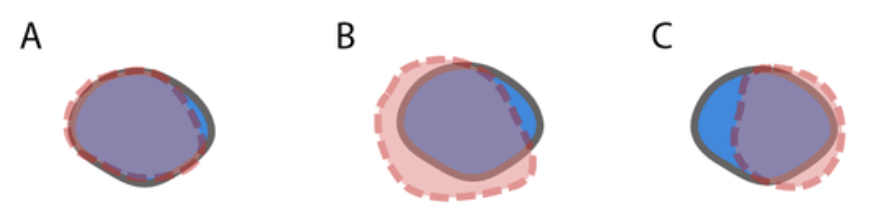

*Source : Kromp, Florian, et al. "Deep Learning architectures for generalized immunofluorescence based nuclear image segmentation." arXiv preprint arXiv:1907.12975 (2019).*

### Question

***How would you implement these metrics?***

In [ ]:
# TODO: Implement each metric given above
# A ground truth and prediction are both provided as example
truth = numpy.array([0, 0, 1, 1, 1, 0, 0, 0, 0])
prediction = numpy.array([0, 0, 1, 1, 0, 0, 0, 1, 0])

# Accuracy

# Precision

# Recall

# F1-score


In the next cell we will display the images that are being thresholded and compared with the annotations from an expert.

In [ ]:
# Display a random image with a number of random crops
# @markdown The number of displayed crops can be increased.
num_crops = 2 # @param {type:'number'}
crop_size = 256

image_name = random.choice(image_names)
show_tp_fp_fn(image_name, num_crops=num_crops, crop_size=crop_size, thresholds=[0.25, 0.25])
pyplot.show()

### Question

***Can you find the optimal threshold for F-Actin rings and fibers?***

Play with the thresholds and see how this influences the TP, FP, and FN regions.

Launch the cell multiple times. Is the optimal threshold always the same on different images? Can you think of a way to find the optimal threshold that should be used?

In [ ]:
# Display a random image
image_name = random.choice(image_names)

def show(rings=0.25, fibers=0.25):
    show_tp_fp_fn(image_name, num_crops=0, thresholds=[rings, fibers])
    pyplot.show()

_ = interact(show, rings=(0, 1, 0.01), fibers=(0, 1, 0.01))

A way of defining the optimal threshold in segmentation is to use try to maximize (or minimize) segmentation metrics. Here, we will be using the Precision-Recall curve. This curve is built by measuring the precision and recall values over the range of possible thresholds.

In the next cell, we show how this curve is built point by point.

***What would be the optimal threshold in this case?***

How would you use this quantitative information to assess multiple images?

In [ ]:
 # Display a random image
image_name = random.choice(image_names)

precision_recall = defaultdict(list)
def show(rings=0.25, fibers=0.25):
    fig, axes, tpfpfn = show_tp_fp_fn(image_name, num_crops=0, thresholds=[rings, fibers])
    colors = {"rings":"green", "fibers":"magenta"}
    for name, threshold, values in zip(["rings", "fibers"], [rings, fibers], tpfpfn):
        tn = numpy.sum(values == 0)
        fn = numpy.sum(values == 1)
        fp = numpy.sum(values == 2)
        tp = numpy.sum(values == 3)

        if tp + fp == 0 or (tp + fp + fn == 0):
            precision = 1
        else:
            precision = tp / (tp + fp)

        if tp + fn == 0:
            recall = 1
        else:
            recall = tp / (tp + fn)

        precision_recall[name].append({
            "precision" : precision,
            "recall" : recall,
            "threshold" : threshold
        })

    for key, values in precision_recall.items():

        values = list(sorted(values, key= lambda x : x["recall"]))

        precision = [value["precision"] for value in values]
        recall = [value["recall"] for value in values]

        axes[1, 0].scatter(recall, precision, label=key, color=colors[key])

    axes[1, 0].get_xaxis().set_visible(True)
    axes[1, 0].get_yaxis().set_visible(True)
    axes[1, 0].set(
        ylim=(0, 1), xlim=(0, 1), ylabel="Precision", xlabel="Recall"
    )
    axes[1, 0].legend()
    pyplot.show()

_ = interact_manual(show, rings=(0, 1, 0.01), fibers=(0, 1, 0.01))

Typically, we would create this curve for multiple images from the **validation dataset** and obtain the threshold that should be used for new images. We have calculated the precision-recall curve on our own validation dataset (not shown here) and the thresholds should be 0.25 for rings and 0.4 for fibers.

*In the next cells, this threshold will be set at this value.*

## Assessment of the performance

We now have access to a trained model but what is its performance on an **unseen** dataset. This dataset is what we call the testing dataset.

All images that are provided within this notebook are part of the testing dataset. This means that all images were not seen by the model during training AND validation.

***It would not be valid to set the thresholds based on the performance from these images which is why we provided the thresholds.***

We first start by looking at the accuracy of the segmentation of the model.

In [ ]:
metrics = ["accuracy"]
scores = get_scores(image_names, metrics=metrics, use_foreground=False)

In [ ]:
COLORS = {
    "rings" : "tab:green",
    "fibers" : "magenta"
}
plot_scores(scores, metrics)
pyplot.show()

Do you think that an accuracy of >90% is accurate based on the segmentations that were displayed earlier in the notebook? It seems a bit high when we look at the images that were generated before. Let's look back at the calculation of the accuracy. One thing to notice if that the number of true negative pixels (TN) is present in this calculation.

\begin{align}
\text{accuracy} &= \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{TN}}
\end{align}

Since most of the image is considered as background (negative pixels), $\text{TN}$ will be much larger that the contribution from $\text{TP}$, $\text{FP}$, and $\text{FN}$. This causes an over-estimation of the performance of the model.

One way to mitigate that is to analyse the performance only in our regions of interest, in our case, the dendritic region. Remember that the F-actin images were also acquired with markers staining for the type of processes that we are looking at. Since the goal of the model is to predict F-actin rings and fibers on dendrites, we will make sure that the performance are representative of the task that we will eventually solve.

First, it requires that we create masks of the dendrites, axons and dendrites without the axons. If you are not familiar with Python, open the images in Fiji/ImageJ and try to threshold them.

The images are stored here: `/content/DL4HBM-2020/raw_data/example-dendrite-images`

### Question

***What would be a good threshold technique that would work on many images in your opinion?***

*Exercice 1:* Implement an automatic threshold for the dendrite and the axon images. Have a look at the automatic threshold methods implemented in [scipy's documentation](https://scikit-image.org/docs/stable/api/skimage.filters.html).

*Exercice 2:* Generate the segmentation mask of the dendrite only, *i.e.* without the contribution from the axon mask. Generate the segmentation mask of the axon only, *i.e.* without the contribution from the dendrite mask.

In [ ]:
# TODO: Implement an automatic thresholding of dendrite and axon signal

# Selects a random image
image_name = random.choice(image_names)
# OR select a specific image
# image_name = image_names[0]

# Loads the image from the tifffiles
image = tifffile.imread(image_name)

# Selects only the dendrite OR axon channels within the image
dendrite = image[DENDRITE_CHAN]
axon = image[AXON_CHAN]

# TODO: Change the thresholded_dendrite / thresholded_axon below
# Hint: Scikit-image provides ways of thresholding an image; see https://scikit-image.org/docs/stable/api/skimage.filters.html
thresholded_dendrite = dendrite
thresholded_axon = axon

numpy.logical_and(thresholded_dendrite, numpy.invert(thresholded_axon))

# Display and image using pyplot
fig, axes = pyplot.subplots(1, 2)
axes[0].imshow(dendrite, cmap="gray")
axes[1].imshow(thresholded_dendrite, cmap="gray")
pyplot.show()

fig, axes = pyplot.subplots(1, 2)
axes[0].imshow(axon, cmap="gray")
axes[1].imshow(thresholded_axon, cmap="gray")
pyplot.show()

In the next cell, we provide our way of defining the foreground signal of the structures. Can you find the method that was used?

In [ ]:
image_name = random.choice(image_names)

show_example_raw_image(image_name, num_crops=0)
show_example_masked_image(image_name, num_crops=0)

pyplot.show()

Now that we have our region of interest we can again evaluate the metrics. However, evaluating a single metric may not be representative of the real performance of a model. Hence, it is common practice to report many metrics that will better define the performance of the model.

In [ ]:
metrics = ["accuracy", "f1_score", "precision", "recall"]
scores = get_scores(image_names, metrics=metrics, use_foreground=True)

In [ ]:
COLORS = {
    "rings" : "tab:green",
    "fibers" : "magenta"
}
plot_scores(scores, metrics)
pyplot.show()

This is great, but how can the model benefit us in the quantification of our data? As previously mentionned, we wish to extract quantitative information from our data, for example, the proportion of the dendritic region that are covered with F-actin rings or fiber patterns.

In [ ]:
# @markdown Run cell. Loads a method to compute the ratios.
def get_ratios(image_names, thresholds=[0.25, 0.40]):

    out = defaultdict(list)
    thresholds = numpy.array(thresholds)[:, numpy.newaxis, numpy.newaxis]
    for image_name in tqdm(image_names, desc="Images"):

        image = tifffile.imread(image_name)
        prediction = tifffile.imread(os.path.join(f"./results/{model_name}", image_name))
        label = tifffile.imread(image_name.replace(".tif", "_label.tif")) > 0

        if image.min() == 2 ** 15:
            image = image - 2 ** 15

        prediction = prediction > thresholds

        dendrite = get_foreground(image[DENDRITE_CHAN])
        axon = get_foreground(image[AXON_CHAN])
        dendrite_no_axon = numpy.logical_and(dendrite, numpy.invert(axon))

        if dendrite_no_axon.sum() < 1:
            continue

        ratio = prediction * dendrite_no_axon[numpy.newaxis, :]
        ratio = ratio.sum(axis=(-2, -1)) / dendrite_no_axon.sum()

        condition = image_name.split(os.path.sep)[-2]
        data = {
            "image_name" : image_name,
            "condition" : condition,
            "ratio" : ratio
        }
        out[condition].append(data)

    return out

data = get_ratios(image_names)

In [ ]:
# @markdown Show the distribution of our data dependant on two different experimental conditions. A `X` marker is used to display the mean of the data.
COLORS = {
    "BLOCK" : "tab:blue",
    "GLU-GLY" : "tab:purple"
}

fig, ax = pyplot.subplots(figsize=(3,3))
for key, values in data.items():
    ratios = numpy.array([value["ratio"] for value in values]) * 100
    ax.scatter(ratios[:, 0], ratios[:, 1], color=COLORS[key], label=key)
    mean = numpy.mean(ratios, axis=0)
    ax.scatter(*mean, color=COLORS[key], marker="X", s=100, edgecolor="black")
ax.set(
    ylim=(0, 100), xlim=(0, 100),
    ylabel="Fibers (%)", xlabel="Rings (%)"
)
ax.legend()
pyplot.show()

# Generalization

A model is said to have good generalization properties when it is able to infer on data that was not part of the training dataset.

Here's some typical situations involving the concept of generalization
1. You trained your model on images that were acquired in 2018 on a given microscope. Is the performance of the model on images that are acquired in 2023 similar or worse? In the former, the model has good generalization properties
1. You trained your model on images that were acquired on microscope A. If you switch the microscopy system to microscope B (same modality), is the performance of the model affected? If not, the model has good generalization.
1. You trained your model to detect cell bodies that were acquired with confocal modality. You recently switched to a widefield microscopy to image the cell bodies. Is the performance of the model affected by this modality switch? If not, the model has good generalization.
1. You trained your model to detect a structure that was stained with dye A. You recently switched to a different dye B because it improves your image quality. Is the performance of the model affected by this switch? If not, the model has good generalization.

We have recently faced challenge (1) in the lab, i.e. the prediction of the model were slightly different than what we had originally.

### Question

***In your opinion, what are the options that could be used to reduce the impact of this shift within the data?***

## Out of distribution images?

We have fine-tuned the original model that was trained with images that were recently acquired.

Two models are available: `actin-dendrite-finetuned` and `actin-dendrite-finetuned-pysted`. `actin-dendrite-finetuned` was finetuned with images that were recently acquired and annotated on our microscope. `actin-dendrite-finetuned-pysted` uses the `pysted` simulation tool to increase the image variability within the dataset to hopefully increase the generalization of the model.

In [ ]:
# @markdown Run cell. Creates the network.

import loader
import network

minmax = numpy.load(os.path.join("raw_data", "minmax.npy"))
pixelsize = 20e-9 # For future reference
networks_infos = {
    "actin-dendrite" : {
        "data_path" : os.path.join("raw_data", "example-generalization-images"),
        "model_path" : os.path.join("trained-networks", "pretrained-unet"),
        "normalization" : loader.NormalizationLayer("minmax", stats={"image_max" : 574.37, "image_min" : 0.0})
    },
    "actin-dendrite-finetuned" : {
        "data_path" : os.path.join("raw_data", "example-generalization-images"),
        "model_path" : os.path.join("trained-networks", "finetuned-unet"),
        "normalization" : loader.NormalizationLayer("quantile")
    },
    "actin-dendrite-finetuned-pysted" : {
        "data_path" : os.path.join("raw_data", "example-generalization-images"),
        "model_path" : os.path.join("trained-networks", "finetuned-pysted-unet"),
        "normalization" : loader.NormalizationLayer("quantile")
    },
}

In [ ]:
# @markdown Select the desired network from the networks informations and loads it.
model_name = "actin-dendrite" #@param ["actin-dendrite", "actin-dendrite-finetuned", "actin-dendrite-finetuned-pysted"]
network_infos = networks_infos[model_name]

# Creation of the model
model = network.UNet(in_channels=1, out_channels=2)
model.load_model(network_infos["model_path"], cuda=CUDA)

# Extracts the images that should be predicted
image_names = glob.glob(os.path.join(network_infos["data_path"], "**/*.tif"), recursive=True)
image_names = list(filter(lambda name: "_label" not in name, image_names))
label_names = [file.replace(".tif", "_label.tif") for file in image_names]

In the next cell we display example images that were recently acquired on our microscope. To your eyes the images may look similar but to a model this may not be the case: the noise may be different, the intensity may not be the same, etc.

In [ ]:
ACTIN_CHAN, AXON_CHAN, DENDRITE_CHAN = 0, 1, 2
# @markdown The number of crops can be updated
num_crops = 2 # @param {type:'number'}
crop_size = 256

image_name = random.choice(image_names)
show_example_raw_image(image_name, num_crops=num_crops, crop_size=crop_size)
pyplot.show()

In [ ]:
# @markdown Launch prediction of the model on all images in the folder.

# Errors may be encountered; This is caused by Google Colab, you may ignore them
for i, (name, image, label, prediction) in enumerate(model.predict_complete_image(
    image_names, image_names, normalization=network_infos["normalization"], cuda=CUDA, step=0.25)):

    # Saves the predictions
    dirname = os.path.dirname(name)
    savefolder = os.path.join(f"/content/DL4HBM-2020/results/{model_name}", dirname)
    os.makedirs(savefolder, exist_ok=True)
    tifffile.imwrite(
        os.path.join(savefolder, os.path.basename(name)),
        prediction.astype(numpy.float32)
    )

    del name, image, label, prediction

In [ ]:
# @markdown Display a random image with a number of random crops
# @markdown The number of crops can be updated.
num_crops = 2 # @param {type:'number'}
crop_size = 256

image_name = random.choice(image_names)
# image_name = image_names[1]
plot_with_crops(image_name, num_crops=num_crops, crop_size=crop_size, show_prediction=True)
pyplot.show()

## Model comparison

In the next cell, we compare the segmentation of the models. In some cases, the segmentation masks may look very similar. However, in some cases the segmentation masks will look very different.

In [ ]:
image_name = random.choice(image_names)

num_crops = 5
compare_model_prediction(
    image_name,
    ["actin-dendrite", "actin-dendrite-finetuned"],
    num_crops=num_crops,
    thresholds = [(0.25, 0.4), (0.14, 0.14)]
)
pyplot.show()

# User Image

In this section we provide a way to analyse a folder of images. To do so, create a folder in the `raw_data` folder (e.g. STEDYCON) and import the images that you would like to analyse in this created folder. In this current state, the model will analyse all images ending in `.tif`. If composite images are used, then make sure that the F-actin channel is the first one.

In [ ]:
import loader
import network

minmax = numpy.load(os.path.join("raw_data", "minmax.npy"))
pixelsize = 20e-9 # For future reference
networks_infos = {
    "actin-dendrite" : {
        "data_path" : os.path.join("raw_data", "STEDYCON"),
        "model_path" : os.path.join("trained-networks", "pretrained-unet"),
        "normalization" : loader.NormalizationLayer("minmax", stats={"image_max" : 574.37, "image_min" : 0.0})
    },
    "actin-dendrite-finetuned" : {
        "data_path" : os.path.join("raw_data", "STEDYCON"),
        "model_path" : os.path.join("trained-networks", "finetuned-unet"),
        "normalization" : loader.NormalizationLayer("quantile")
    },
    "actin-dendrite-finetuned-pysted" : {
        "data_path" : os.path.join("raw_data", "STEDYCON"),
        "model_path" : os.path.join("trained-networks", "finetuned-pysted-unet"),
        "normalization" : loader.NormalizationLayer("quantile")
    },
}

In [ ]:
# Selects the desired network from the networks informations and loads it
model_name = "actin-dendrite-finetuned-pysted"
network_infos = networks_infos[model_name]

# Creation of the model
model = network.UNet(in_channels=1, out_channels=2)
model.load_model(network_infos["model_path"], cuda=CUDA)

# Extracts the images that should be predicted
image_names = glob.glob(os.path.join(network_infos["data_path"], "**/*.tif"), recursive=True)

In [ ]:
# Errors may be encountered; This is caused by Google Colab, you may ignore them
for i, (name, image, label, prediction) in enumerate(model.predict_complete_image(
    image_names, image_names, normalization=network_infos["normalization"], cuda=CUDA, step=0.25)):

    # Saves the predictions
    dirname = os.path.dirname(name)
    savefolder = os.path.join(f"/content/DL4HBM-2020/results/{model_name}", dirname)
    os.makedirs(savefolder, exist_ok=True)
    tifffile.imwrite(
        os.path.join(savefolder, os.path.basename(name)),
        prediction.astype(numpy.float32)
    )

    del name, image, label, prediction

In [ ]:
# Display a random image with a number of random crops
num_crops = 2
crop_size = 256

image_name = random.choice(image_names)
# image_name = image_names[1]
plot_with_crops(image_name, num_crops=num_crops, crop_size=crop_size, show_prediction=True)
pyplot.show()

In [ ]:
image_name = random.choice(image_names)

num_crops = 5
compare_model_prediction(
    image_name,
    ["actin-dendrite", "actin-dendrite-finetuned-pysted"],
    num_crops=num_crops,
    thresholds = [(0.25, 0.4), (0.14, 0.14)]
)
pyplot.show()